# Federated learning for tabular data - Breast Cancer Dataset

References:
- https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification
- https://stackoverflow.com/questions/58965488/how-to-create-federated-dataset-from-a-csv-file
- https://www.youtube.com/watch?v=JBNas6Yd30A&ab_channel=GoogleTechTalks 


To make sure that your environment is correctly setup, run the following. 
If you don't see a greeting, refer to the [Installation](https://www.tensorflow.org/federated/install) guide for instructions.

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
# !pip3 install numpy

# TODO:
# client proportions
# number clients
# size 
# different type of clients?

# simulate clients
# realistic preprocessing

In [2]:
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import reshape, nest, config
from tensorflow.keras.datasets import mnist
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
from sklearn import preprocessing
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

### Loading and preparing the tabular input data

Federated learning requires a federated data set, i.e., a collection of data from multiple users. 
The TFF has a few federated datasets, but in this notebook, we will be converting a tabular dataset to a federated one. 

In [232]:
datapath = '/ssd003/projects/pets/datasets/home_credit/home_credit_train.csv'
data = pd.read_csv(datapath)
data
#data = data.head(2000)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,target
0,-0.577538,0.142129,-0.478095,-0.166149,-0.507465,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,1
1,-0.577538,0.426792,1.725450,0.592677,1.600698,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
2,-0.577538,-0.427196,-1.152888,-1.404676,-1.092389,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
3,-0.577538,-0.142533,-0.711430,0.177869,-0.653696,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
4,-0.577538,-0.199466,-0.213734,-0.361755,-0.068772,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.577538,-0.047646,-0.855489,0.031009,-0.848671,0.845396,1.537586,-0.453377,-0.984955,0.670578,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
307507,-0.577538,-0.408219,-0.818594,-1.042339,-0.848671,0.310593,-1.085707,2.133617,0.169782,-0.725959,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
307508,-0.577538,-0.066623,0.195379,0.198050,0.126202,-1.147120,0.245417,-0.507774,-0.497002,-1.428203,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,0
307509,-0.577538,0.009287,-0.568757,-0.476324,-0.592767,-1.124635,0.934008,-0.485583,0.688107,1.366859,...,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,1


In [233]:
data.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,target
count,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,307511.000000
mean,-3.225633e-17,-1.220299e-17,-3.880695e-17,4.621251e-17,6.585514e-16,3.335850e-16,3.350407e-17,4.311627e-17,-6.469751e-18,6.757424e-17,...,-4.944738e-18,2.463127e-17,4.898526e-18,-2.952402e-17,3.512151e-18,-1.899334e-17,-7.625064e-18,-1.940925e-18,6.053839e-18,0.080729
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.272419
min,-5.775378e-01,-6.036870e-01,-1.376496e+00,-1.758940e+00,-1.348293e+00,-1.487798e+00,-2.106335e+00,-5.784940e-01,-5.588007e+00,-2.784328e+00,...,-5.947728e-02,-5.426904e-02,-3.480198e-02,-1.001382e-01,-1.633182e-02,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,0.000000
25%,-5.775378e-01,-2.374210e-01,-8.174760e-01,-7.303015e-01,-8.121132e-01,-7.853308e-01,-8.352476e-01,-4.712426e-01,-7.077673e-01,-8.644204e-01,...,-5.947728e-02,-5.426904e-02,-3.480198e-02,-1.001382e-01,-1.633182e-02,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,0.000000
50%,-5.775378e-01,-9.129414e-02,-2.124151e-01,-1.521775e-01,-2.393752e-01,-1.459095e-01,6.576450e-02,-4.602923e-01,1.368540e-01,-1.721143e-01,...,-5.947728e-02,-5.426904e-02,-3.480198e-02,-1.001382e-01,-1.633182e-02,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,0.000000
75%,8.072731e-01,1.421293e-01,5.208178e-01,5.166083e-01,3.821064e-01,5.635704e-01,8.304332e-01,-4.537519e-01,8.447974e-01,8.441512e-01,...,-5.947728e-02,-5.426904e-02,-3.480198e-02,-1.001382e-01,-1.633182e-02,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,0.000000
max,2.573387e+01,4.927034e+02,8.574059e+00,1.593252e+01,9.509356e+00,3.733564e+00,1.958761e+00,2.133617e+00,1.415353e+00,1.983641e+00,...,1.681314e+01,1.842671e+01,2.873400e+01,9.986201e+00,6.123017e+01,1.104556e+01,4.098034e+01,4.438721e+01,5.463098e+01,1.000000


In [234]:
df = data

In [235]:
# del data['Unnamed: 32']
# del data['id']
# print(data.shape)
# data['diagnosis'] = data['diagnosis'].str.replace('M','1')
# data['diagnosis'] = data['diagnosis'].str.replace('B','0')
# data["diagnosis"] = pd.to_numeric(data["diagnosis"])

# new = data.copy()
# del new['diagnosis']
# x = new.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)
# df.columns

In [236]:
new = df.copy()
data['features']= new.values.tolist()
print(data)

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          -0.577538          0.142129   -0.478095    -0.166149   
1          -0.577538          0.426792    1.725450     0.592677   
2          -0.577538         -0.427196   -1.152888    -1.404676   
3          -0.577538         -0.142533   -0.711430     0.177869   
4          -0.577538         -0.199466   -0.213734    -0.361755   
...              ...               ...         ...          ...   
307506     -0.577538         -0.047646   -0.855489     0.031009   
307507     -0.577538         -0.408219   -0.818594    -1.042339   
307508     -0.577538         -0.066623    0.195379     0.198050   
307509     -0.577538          0.009287   -0.568757    -0.476324   
307510     -0.577538         -0.047646    0.188760     1.518545   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0             -0.507465                   -0.149452    1.506880   
1              1.600698                   -1.252750   -0.1668

### To simulate FL, we'll make a new column for "hospital_id" --> id: 1, 2, 3, 4

In [237]:
data['hospital_id'] = np.random.randint(1,5, size=len(data))

In [238]:
data = data[['target', 'hospital_id', 'features']]

In [239]:
data

,target,hospital_id,features
0,1,3,"[-0.5775378417542217, 0.142129252374572, -0.47..."
1,0,3,"[-0.5775378417542217, 0.426791930024181, 1.725..."
2,0,1,"[-0.5775378417542217, -0.4271961029246461, -1...."
3,0,4,"[-0.5775378417542217, -0.14253342527503704, -0..."
4,0,3,"[-0.5775378417542217, -0.19946596080495885, -0..."
...,...,...,...
307506,0,3,"[-0.5775378417542217, -0.0476458660585007, -0...."
307507,0,2,"[-0.5775378417542217, -0.4082185910813388, -0...."
307508,0,3,"[-0.5775378417542217, -0.06662337790180796, 0...."
307509,1,3,"[-0.5775378417542217, 0.009286669471421113, -0..."


For this tutorial, we have 4 hospitals. We will train on 3 clients.

In [244]:
client_id_colname = 'hospital_id' #column that represents client ID 
number_of_training_clients = 3

# split client_id into train and test clients
client_ids = data[client_id_colname].unique()
train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
test_client_ids = [x for x in client_ids if x not in train_client_ids]

In [245]:
train_client_ids

[1, 2, 3]

The function `tff.simulation.ClientData.from_clients_and_fn`, requires that we write a function that accepts a `client_id` as input and returns a `tf.data.Dataset`. Let's do that in the helper function below: 

In [246]:
SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 10
def create_tf_dataset_for_client_fn(client_id):
    client_data = data[data[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [247]:
if tff.__version__ < "0.19.0":

    train_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=train_client_ids,   
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.ClientData.from_clients_and_fn(
        client_ids=test_client_ids,
        create_tf_dataset_for_client_fn=create_tf_dataset_for_client_fn)
else:
    train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=train_client_ids, 
        serializable_dataset_fn=create_tf_dataset_for_client_fn)
    
    test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=test_client_ids,
        serializable_dataset_fn=create_tf_dataset_for_client_fn)

### Example dataset 

Each element of example_dataset is a Python dictionary where the keys are strings representing feature names, and the values are tensors with one batch of those features. Now, you have a federated dataset that can be preprocessed and used for modeling.

In [248]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[2]
    )
print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

<RepeatDataset element_spec={'target': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'hospital_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'features': TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)}>
{'target': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, 'hospital_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'features': <tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[-5.77537835e-01, -4.74639893e-01,  1.71264827e+00,
         7.37673938e-01,  1.58851182e+00, -7.85330772e-01,
        -1.46930158e+00,  2.13361740e+00, -1.62136626e+00,
        -8.61107945e-01, -1.44434083e+00,  1.80330989e-03,
        -2.13357520e+00, -4.99013036e-01,  4.32445444e-02,
         1.59933686e+00, -2.45215252e-01, -1.67639494e-01,
        -1.03064351e-01, -6.26985356e-02, -6.31821275e-01,
        -1.24004222e-01, -2.31266633e-01, -2.05868647e-01,
        -2.91207880e-01, -5.47235489e-01, -4.67814147e-01,
        -1

2022-08-24 10:20:02.311559: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


### Exploring heterogeneity in federated data


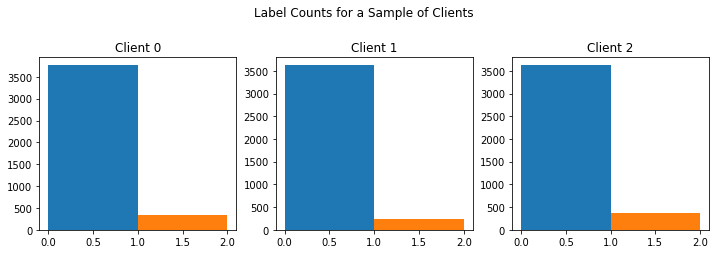

In [202]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in [0,1,2]:
    client_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        label = example['target'].numpy()[0]
        plot_data[label].append(label)
    plt.subplot(2, 3, i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(
        plot_data[j],
        bins=[0, 1, 2])

From the above steps, we now have a federated dataset that can be preprocessed and used for modeling. 



### Preprocessing the input data
We will now shuffle the individual examples, organize them into batches, and rename the features
from `features` and `diagnosis` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [249]:
n_features = len(data['features'][0])
n_features

99

In [271]:
NUM_ROUNDS = 5
NUM_EPOCHS = 5
BATCH_SIZE = 5000
PREFETCH_BUFFER = 2500
def preprocess(dataset):
    def batch_format_fn(element):
                
        return collections.OrderedDict(x= tf.reshape(element['features'], [-1,n_features]),
                                       y=tf.reshape(element['target'], [-1,1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

Let's verify this worked.

In [272]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[-0.57753783, -0.14253342, -1.0410839 , ..., -0.02252901,
                      -0.01830463,  0.        ],
                     [ 0.80727315,  0.33190438, -0.6023651 , ..., -0.02252901,
                      -0.01830463,  0.        ],
                     [-0.57753783,  0.33190438, -0.37026003, ..., -0.02252901,
                      -0.01830463,  0.        ],
                     ...,
                     [ 0.80727315, -0.23742099, -0.01606499, ..., -0.02252901,
                      -0.01830463,  0.        ],
                     [-0.57753783,  0.14212926, -0.817476  , ..., -0.02252901,
                      -0.01830463,  0.        ],
                     [-0.57753783, -0.23742099, -0.8554893 , ..., -0.02252901,
                      -0.01830463,  1.        ]], dtype=float32)),
             ('y',
              array([[0],
                     [0],
                     [0],
                     ...,
                     [0],
                    

In [273]:
sample_batch['x'].shape, sample_batch['y'].shape

((5000, 99), (5000, 1))

We now have almost all the building blocks in place to construct federated datasets.

One of the ways to feed federated data to TFF in a simulation is simply as a Python list, with each element of the list holding the data of an individual user, as a `tf.data.Dataset`. Since we already have an interface for that, let's use it.

The helper function `make_federated_data` below will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [274]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

So now, how do we choose the clients? 

In a typical federated training scenario, we might have only a fraction of the devices available for training at a given point in time. But, since we are in a simulation environment, all the data is locally available. Typically then, when running simulations, we would simply sample a random subset of the clients to be involved in each round of training, generally different in each round.

That said, as you can find out by studying the paper on the [Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled subsets of clients in each round can take a while, and it would be impractical to have to run hundreds of rounds in this interactive tutorial.

For simplicity here, we will sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data). 

In [275]:
%%time
train_client_ids = sample(client_ids.tolist(), number_of_training_clients)
federated_train_data = make_federated_data(train_data, train_data.client_ids)
print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 3
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>
CPU times: user 1min 8s, sys: 1.19 s, total: 1min 9s
Wall time: 1min 9s


In [276]:
federated_train_data, len(federated_train_data)

([<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
  <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
  <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>],
 3)

In [277]:
federated_train_data[0]

<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>

### Creating a model with Keras 
Here's an example of a simple model:

In [278]:
!nvidia-smi

Wed Aug 24 11:29:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:87:00.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |  14228MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [279]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(n_features,)), # n_features
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

Note that we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

If you have a Keras model like the one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.from_keras_model`, passing the model and a sample data batch as
arguments, as shown below.


In [280]:
import tensorflow_addons as tfa

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])

### Training the model on federated data 

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a **Federated Averaging** algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`, as follows.

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset.

We will start with regular SGD and a smaller learning rate than usual. 


In [281]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)) 

In this case, the two computations generated and packed into iterative_process implement Federated Averaging.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [282]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[99,150],float32[150],float32[150,50],float32[50],float32[50,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

While the above type signature may at first seem a bit cryptic, you can recognize that the server state consists of a model (the initial model parameters for MNIST that will be distributed to all devices), and optimizer_state (additional information maintained by the server, such as the number of rounds to use for hyperparameter schedules, etc.).

Let's invoke the initialize computation to construct the server state.

In [283]:
state = iterative_process.initialize()

In [284]:
state

ServerState(model=ModelWeights(trainable=[array([[ 0.1402174 ,  0.05599581,  0.0423145 , ...,  0.0556366 ,
        -0.14524269,  0.152809  ],
       [ 0.0332641 , -0.05884849, -0.06688308, ..., -0.15298617,
        -0.05856832, -0.14479299],
       [-0.1322629 , -0.03222283, -0.00397469, ...,  0.00036751,
         0.05312352, -0.02445459],
       ...,
       [ 0.13980097,  0.04177453, -0.05495314, ...,  0.10104412,
        -0.05193351,  0.08287957],
       [ 0.08678132, -0.08095548, -0.12980767, ..., -0.10250229,
        -0.01463902,  0.08797938],
       [ 0.15123183, -0.02688025, -0.05861281, ...,  0.03475092,
        -0.02146557,  0.12065235]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [285]:
federated_train_data

[<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>]

In [286]:
state.model

ModelWeights(trainable=[array([[ 0.1402174 ,  0.05599581,  0.0423145 , ...,  0.0556366 ,
        -0.14524269,  0.152809  ],
       [ 0.0332641 , -0.05884849, -0.06688308, ..., -0.15298617,
        -0.05856832, -0.14479299],
       [-0.1322629 , -0.03222283, -0.00397469, ...,  0.00036751,
         0.05312352, -0.02445459],
       ...,
       [ 0.13980097,  0.04177453, -0.05495314, ...,  0.10104412,
        -0.05193351,  0.08287957],
       [ 0.08678132, -0.08095548, -0.12980767, ..., -0.10250229,
        -0.01463902,  0.08797938],
       [ 0.15123183, -0.02688025, -0.05861281, ...,  0.03475092,
        -0.02146557,  0.12065235]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
%%time
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [59]:
NUM_ROUNDS = 3
for round_num in range(2, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, metrics))
    print("--")

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('binary_accuracy', 0.85864705), ('Precision', 0.096476786), ('Recall', 0.10371681), ('AUC', 0.54178023), ('loss', 0.5347716)])), ('stat', OrderedDict([('num_examples', 37325)]))])
--


Training loss is decreasing after each round of federated training, indicating
the model is converging

Next, let's visualize the metrics from these federated computations using Tensorboard.

Let's start by creating the directory and the corresponding summary writer to write the metrics to.

In [267]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [268]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_test_data = make_federated_data(test_data, test_client_ids)

In [270]:
%%time
NUM_ROUNDS = 10
MAX_STD = 0.001
loss = list()
accuracy = list()
val_loss = list()
val_accuracy = list()
precision = list()
recall = list()
f1 = list()
val_precision = list()
val_recall = list()
val_f1 = list() 
train_AUC = list()
val_AUC = list() 

with summary_writer.as_default():
    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        val_metrics = evaluation(state.model, federated_test_data)
        
        my_precision = metrics['train']['Precision']
        precision.append(my_precision)
        
        my_recall = metrics['train']['Recall']
        recall.append(my_recall)
        
        my_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall)
        f1.append(my_f1)
        
        val_precision.append(val_metrics['eval']['Precision'])
        val_recall.append(val_metrics['eval']['Recall'])
        my_val_f1 = 2 * (val_metrics['eval']['Precision'] * val_metrics['eval']['Recall']) / (val_metrics['eval']['Precision'] + val_metrics['eval']['Recall'])
        val_f1.append(my_val_f1)
        
        my_loss = metrics['train']['loss']
        
        train_AUC.append(metrics['train']['AUC'])
        val_AUC.append(val_metrics['eval']['AUC'])
        
        loss.append(metrics['train']['loss'])
        accuracy.append(metrics['train']['binary_accuracy'])
        my_acc = val_metrics['eval']['binary_accuracy']
        val_loss.append(val_metrics['eval']['loss'])
        val_accuracy.append(val_metrics['eval']['binary_accuracy'])
        print(f"round: {round_num:2d}, loss: {my_loss}, test_accuracy: {val_accuracy}, training_recall : {my_recall}, training_precision = {my_precision}, training_f1 = {my_f1}, val_precision = {val_metrics['eval']['Precision']}, val_recall = {val_metrics['eval']['Recall']}, val_f1 = {my_val_f1}")
        for name, value in metrics['train'].items():
            tf.summary.scalar(name, value, step=round_num)

round:  1, loss: 0.42400479316711426, test_accuracy: [0.75567347], training_recall : 0.042960647493600845, training_precision = 0.15482592582702637, training_f1 = 0.06725858102985015, val_precision = 0.13594040274620056, val_recall = 0.3722709119319916, val_f1 = 0.19915596271848832


KeyboardInterrupt: 

In [160]:
federated_test_data = make_federated_data(test_data, test_client_ids)
print(federated_test_data)

[<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>]


In [37]:
%load_ext tensorboard

In [38]:
!ls {logdir}
%tensorboard --host 0.0.0.0 --logdir {logdir} --port=6004

events.out.tfevents.1661344296.gpu061.cluster.local.17922.0.v2


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Text(0.5, 0, 'Round')

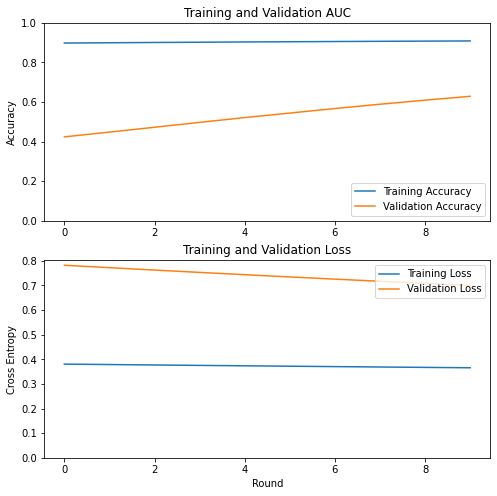

In [161]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation AUC')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Round')

# plt.savefig('./figures/DELIRIUM_normalized_TFF_accuracy_loss_10_rounds.png')


Text(0.5, 0, 'Round')

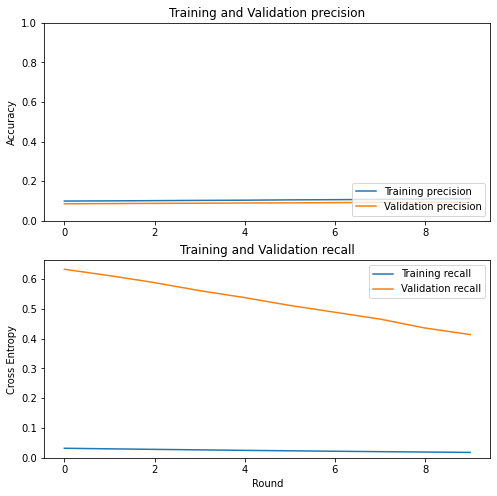

In [162]:
fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(2, 1, 1)
ax1.plot(precision, label='Training precision')
ax1.plot(val_precision, label='Validation precision')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title('Training and Validation precision')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.plot(recall, label='Training recall')
ax2.plot(val_recall, label='Validation recall')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation recall')
ax2.set_xlabel('Round')


In [163]:
train_metrics = evaluation(state.model, federated_train_data)

In [164]:
str(train_metrics)

"OrderedDict([('eval', OrderedDict([('binary_accuracy', 0.63111234), ('Precision', 0.09616739), ('Recall', 0.4241564), ('AUC', 0.5457027), ('loss', 0.6979991)])), ('stat', OrderedDict([('num_examples', 5772625)]))])"

In [43]:
test_metrics = evaluation(state.model, federated_test_data)

In [44]:
str(test_metrics)

"OrderedDict([('eval', OrderedDict([('binary_accuracy', 0.8106509), ('Precision', 0.067567565), ('Recall', 0.15625), ('AUC', 0.46569082), ('loss', 0.57125044)])), ('stat', OrderedDict([('num_examples', 12675)]))])"

In [169]:
federated_train_data

[<PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>]